# Introduction
In the Intro to SQL micro-course, you learned how to use aggregate functions, which perform calculations based on sets of rows. In this tutorial, you'll learn how to define analytic functions, which also operate on a set of rows. However, unlike aggregate functions, analytic functions return a (potentially different) value for each row in the original table.

Analytic functions allow us to perform complex calculations with relatively straightforward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.

# Syntax
To understand how to write analytic functions, we'll work with a small table containing data from two different people who are training for a race. The `id` column identifies each runner, the `date` column holds the day of the training session, and `time` shows the time (in minutes) that the runner dedicated to training. Say we'd like to calculate a moving average of the training times for each runner, where we always take the average of the current and previous training sessions. We can do this with the following query:
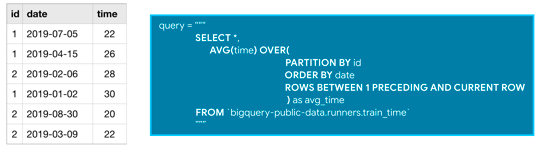

All analytic functions have an **OVER** clause, which defines the sets of rows used in each calculation. The **OVER** clause has three (optional) parts:

- The **PARTITION BY** clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.
- The **ORDER BY** clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.
- The final clause (`ROWS BETWEEN 1 PRECEDING AND CURRENT ROW`) is known as a **window frame** clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (Actually, analytic functions are sometimes referred to as analytic window functions or simply window functions!)

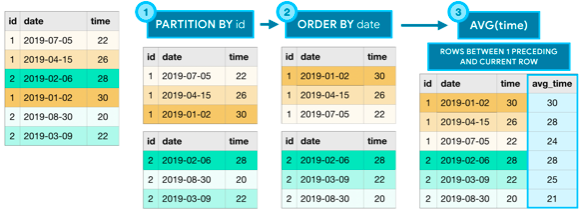
## (More on) window frame clauses
There are many ways to write window frame clauses:

- `ROWS BETWEEN 1 PRECEDING AND CURRENT ROW` - the previous row and the current row.
- `ROWS BETWEEN 3 PRECEDING AND 1 FOLLOWING` - the 3 previous rows, the current row, and the following row.
- `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING` - all rows in the partition.

Of course, this is not an exhaustive list, and you can imagine that there are many more options! In the code below, you'll see some of these clauses in action.


# Three types of analytic functions
The example above uses only one of many analytic functions. BigQuery supports a wide variety of analytic functions, and we'll explore a few here. For a complete listing, you can take a look at the documentation.

### 1) Analytic aggregate functions

As you might recall, **AVG()** (from the example above) is an aggregate function. The **OVER** clause is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value.

**MIN()** (or **MAX()**) - Returns the minimum (or maximum) of input values
**AVG()** (or **SUM()**) - Returns the average (or sum) of input values
**COUNT()** - Returns the number of rows in the input

### 2) Analytic navigation functions

Navigation functions assign a value based on the value in a (usually) different row than the current row.

**FIRST_VALUE()** (or **LAST_VALUE()**) - Returns the first (or last) value in the input
**LEAD()** (and **LAG()**) - Returns the value on a subsequent (or preceding) row

### 3) Analytic numbering functions

Numbering functions assign integer values to each row based on the ordering.

**ROW_NUMBER()** - Returns the order in which rows appear in the input (starting with 1)
**RANK()** - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

### Example

We'll work with the [San Francisco Open Data dataset](https://www.kaggle.com/datasf/san-francisco). We begin by reviewing the first several rows of the `bikeshare_trips` table. (The corresponding code is hidden, but you can un-hide it by clicking on the "Code" button below.)

In [2]:
from google.cloud import bigquery

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


Each row of the table corresponds to a different bike trip, and we can use an analytic function to calculate the cumulative number of trips for each date in 2015.

In [3]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

,trip_date,num_trips,cumulative_trips
0,2015-01-01,181,181
1,2015-01-02,428,609
2,2015-01-03,283,892
3,2015-01-04,206,1098
4,2015-01-05,1186,2284


The query uses a **common table expression (CTE)** to first calculate the daily number of trips. Then, we use **SUM()** as an aggregate function.

- Since there is no **PARTITION BY** clause, the entire table is treated as a single partition.
- The **ORDER BY** clause orders the rows by date, where earlier dates appear first.
- By setting the **window frame** clause to `ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW`, we ensure that all rows up to and including the current date are used to calculate the (cumulative) sum. (Note: If you read the documentation, you'll see that this is the default behavior, and so the query would return the same result if we left out this window frame clause.)

The next query tracks the stations where each bike began (in `start_station_id`) and ended (in `end_station_id`) the day on October 25, 2015.

In [4]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

,bike_number,trip_time,first_station_id,last_station_id,start_station_id,end_station_id
0,22,13:25:00,2,16,2,16
1,25,11:43:00,77,51,77,60
2,25,12:14:00,77,51,60,51
3,29,14:59:00,46,74,46,60
4,29,21:23:00,46,74,60,74


The query uses both **FIRST_VALUE()** and **LAST_VALUE()** as analytic functions.

- The **PARTITION BY** clause breaks the data into partitions based on the `bike_numbe` column. Since this column holds unique identifiers for the bikes, this ensures the calculations are performed separately for each bike.
- The **ORDER BY** clause puts the rows within each partition in chronological order.
- Since the window frame clause is `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWIN`, for each row, its entire partition is used to perform the calculation. (This ensures the calculated values for rows in the same partition are identical.)